I_scaled: min 0.0000, max 1.0000
Rpd_scaled: min 0.0000, max 1.0000
Total samples: 219
Split → Train: 153, Val: 32, Test: 34
Final Test Accuracy: 0.941021 | K=0.1097 | Train Acc=1.000


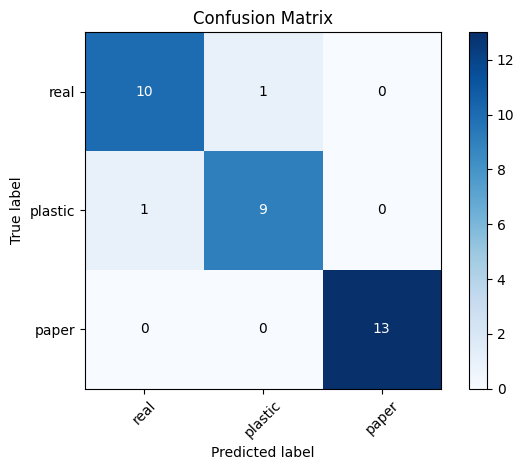

In [29]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

# 0. 设备设置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 数据加载 & 归一化
E   = pd.read_excel("E.xlsx",   header=None).values        # (64,21)
Rpd = pd.read_excel("Rpd.xlsx", header=None).values        # (64,)
d_lambda = 2.0
file_info = [
    ("I_real.xlsx",    "RE_real.xlsx",    0),
    ("I_plastic.xlsx", "RE_plastic.xlsx", 1),
    ("I_paper.xlsx",   "RE_paper.xlsx",   2),
]
I_list, RE_list, labels_list = [], [], []
for I_file, RE_file, label in file_info:
    I_tmp  = pd.read_excel(I_file,  header=None).values
    RE_tmp = pd.read_excel(RE_file, header=None).values / 100.0
    I_list.append(I_tmp.T)
    RE_list.append(RE_tmp.T)
    labels_list.append(np.full((I_tmp.shape[1],), label, dtype=int))
I_all  = np.vstack(I_list)
RE_all = np.vstack(RE_list)
labels = np.hstack(labels_list)

# Min-Max 缩放
i_min, i_max = I_all.min(), I_all.max()
I_scaled     = (I_all - i_min) / (i_max - i_min)
rpd_min, rpd_max = Rpd.min(), Rpd.max()
rpd_scaled   = (Rpd - rpd_min) / (rpd_max - rpd_min)
print(f"I_scaled: min {I_scaled.min():.4f}, max {I_scaled.max():.4f}")
print(f"Rpd_scaled: min {rpd_scaled.min():.4f}, max {rpd_scaled.max():.4f}")
print(f"Total samples: {I_scaled.shape[0]}")

# 2. Dataset 定义
class SpectraClsDataset(Dataset):
    def __init__(self, I_data, RE_data, labels):
        self.I      = torch.tensor(I_data, dtype=torch.float32)
        self.RE     = torch.tensor(RE_data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.I)
    def __getitem__(self, idx):
        return self.I[idx], self.RE[idx], self.labels[idx]

dataset = SpectraClsDataset(I_scaled, RE_all, labels)
n = len(dataset)

# 3. 样本划分：随机打散再划分
train_len = int(0.7 * n)
val_len   = int(0.15 * n)
test_len  = n - train_len - val_len
torch.manual_seed(4)
perm       = torch.randperm(n)
train_idx  = perm[:train_len].tolist()
val_idx    = perm[train_len:train_len+val_len].tolist()
test_idx   = perm[train_len+val_len:].tolist()
train_set  = Subset(dataset, train_idx)
val_set    = Subset(dataset, val_idx)
test_set   = Subset(dataset, test_idx)
print(f"Split → Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

# 4. DataLoader
batch_size   = 256
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

# 5. 多任务模型定义
class MultiTaskPINN(nn.Module):
    def __init__(self, num_LEDs, num_wavelengths, num_classes):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm1d(16), nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32), nn.ReLU(),
        )
        self.recon_decoder = nn.Sequential(
            nn.Linear(32 * num_LEDs, 1024), nn.ReLU(),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, num_wavelengths), nn.Sigmoid(),
        )
        self.classifier = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # → (B,128,1)
            nn.Flatten(),             # → (B,128)
            nn.Linear(64, num_classes)
        )


    def forward(self, x):
        x = x.unsqueeze(1)                        # (B,1,21)
        z = self.encoder(x)                       # (B,32,21)
        # —— 计算一阶导数并拼接 —— 
        dz = z[:, :, 1:] - z[:, :, :-1]            # (B,32,L-1)
        dz = F.pad(dz, (0,1), mode='replicate')    # (B,32,L)，尾部复制填充
        feat = torch.cat([z, dz], dim=1)           # (B,64,L)

        # —— 重建分支 —— 
        z_flat = z.view(z.size(0), -1)
        RE_pred = self.recon_decoder(z_flat)
        # 分类分支直接使用特征图 z
        logits = self.classifier(feat)
        return RE_pred, logits

# 6. 物理核
E_t   = torch.tensor(E, dtype=torch.float32).to(device)
Rpd_t = torch.tensor(rpd_scaled, dtype=torch.float32).to(device)
kernel= (E_t * Rpd_t.unsqueeze(1)) * d_lambda

# 7. 损失与优化设置
model = MultiTaskPINN(num_LEDs=E.shape[1], num_wavelengths=E.shape[0], num_classes=3).to(device)
K     = torch.nn.Parameter(torch.tensor(0.05, dtype=torch.float32, device=device), requires_grad=True)
optimizer = optim.AdamW([
    {'params': model.parameters(), 'lr':1e-3},
    {'params': [K],             'lr':1e-2},
], weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, min_lr=1e-6)

mse_loss = nn.MSELoss()
ce_loss  = nn.CrossEntropyLoss()
alpha, beta, gamma, lam = 1, 0.25, 0.1, 1
epsilon = 1e-6

def spectral_smoothness(RE_pred):
    diff2 = RE_pred[:,2:] - 2*RE_pred[:,1:-1] + RE_pred[:,:-2]
    return diff2.pow(2).mean()
def tv_loss(RE):
    return (RE[:,:-1] - RE[:,1:]).abs().mean()

# 8. 三阶段训练及状态打印
pretrain_epochs   = 500
finetune_epochs  = 500
classify_epochs  = 5000
total_epochs     = pretrain_epochs + finetune_epochs + classify_epochs
history = []
for epoch in range(1, total_epochs+1):
    # 阶段三开始：冻结 encoder/decoder/K
    if epoch == pretrain_epochs + finetune_epochs + 1:
        for p in model.encoder.parameters():     p.requires_grad = False
        for p in model.recon_decoder.parameters(): p.requires_grad = False
        K.requires_grad = False
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    for I_batch, RE_batch, lbl_batch in train_loader:
        Ib, Rb, Lb = I_batch.to(device), RE_batch.to(device), lbl_batch.to(device)
        optimizer.zero_grad()
        RE_pred, logits = model(Ib)
        loss_recon = mse_loss(RE_pred, Rb)
        loss_s    = spectral_smoothness(RE_pred)
        loss_tv   = tv_loss(RE_pred)
        loss_I    = (Ib/(Ib.max(dim=1,keepdim=True)[0]+epsilon)*((K*(RE_pred@kernel))-Ib).pow(2)).mean()
        loss_cls  = ce_loss(logits, Lb)
        if epoch <= pretrain_epochs:
            loss = alpha*loss_recon + beta*loss_s + gamma*loss_tv
        elif epoch <= pretrain_epochs + finetune_epochs:
            loss = alpha*loss_recon + beta*loss_s + gamma*loss_tv + lam * loss_I
        else:
            loss = loss_cls
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()*Ib.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds==Lb).sum().item()
        running_total += Ib.size(0)
    epoch_loss = running_loss / running_total
    epoch_acc  = running_correct / running_total
    print(f"Epoch {epoch}/{total_epochs} | Loss={epoch_loss:.4f} | K={K.item():.4f} | Train Acc={epoch_acc:.3f}", end='\r', flush=True)
    history.append([epoch, epoch_loss, K.item(), epoch_acc])
    
history_df = pd.DataFrame(history, columns=['epoch', 'loss', 'K', 'acc'])
history_df.to_excel('train_history.xlsx', index=False)


# 9. 测试 & 混淆矩阵
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for I_batch, RE_batch, lbl_batch in test_loader:
        Ib, Lb = I_batch.to(device), lbl_batch.to(device)
        _, logits = model(Ib)
        preds = logits.argmax(dim=1)
        y_true.extend(Lb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
cm = confusion_matrix(y_true, y_pred)
pred_accuracy = np.mean(np.array(y_true)==np.array(y_pred))
print(f"Final Test Accuracy: {pred_accuracy:.3f}")
np.savetxt('confusion_matrix.csv', cm, delimiter=',', fmt='%d')
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes=['real','plastic','paper']
plt.xticks(range(3), classes, rotation=45)
plt.yticks(range(3), classes)
thresh = cm.max()/2.
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,cm[i,j],ha='center',va='center',color='white' if cm[i,j]>thresh else 'black')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=600)
plt.show()


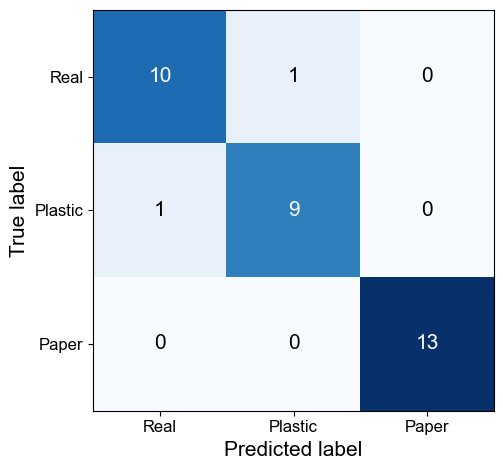

In [39]:
plt.rcParams['font.family'] = 'Arial'
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classes=['Real','Plastic','Paper']
plt.xticks(range(3), classes, fontsize=12)
plt.yticks(range(3), classes, fontsize=12)
thresh = cm.max()/2.
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j,i,cm[i,j],ha='center',va='center',color='white' if cm[i,j]>thresh else 'black', fontsize=15)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=600)
plt.show()

Running t-SNE with perplexity=11, samples=34


C:\Users\liuze\miniconda3\envs\pytorch_env\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


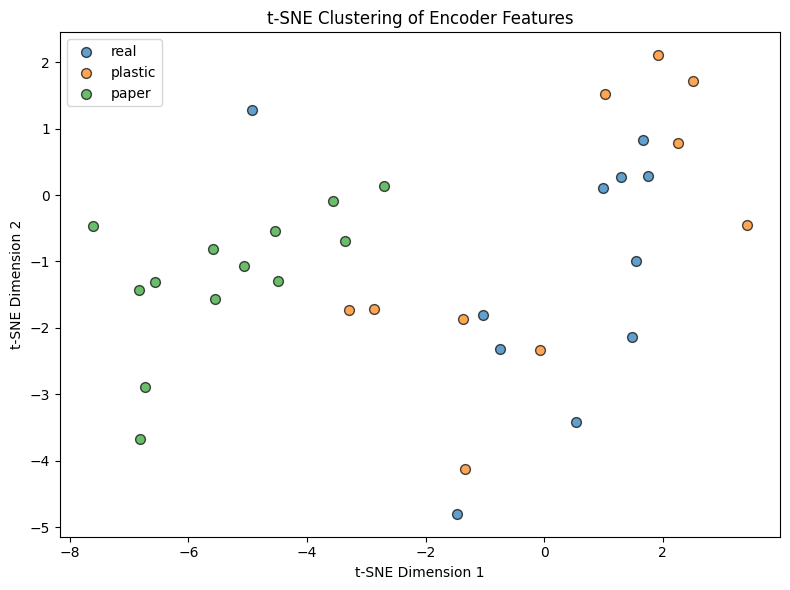

In [30]:
from sklearn.manifold import TSNE

# Step 10: t-SNE 聚类可视化
model.eval()
features, labels_true = [], []
with torch.no_grad():
    for I_batch, RE_batch, lbl_batch in test_loader:
        Ib = I_batch.to(device)
        z = model.encoder(Ib.unsqueeze(1))  # (B,32,21)
        z_flat = z.permute(0,2,1).reshape(z.shape[0], -1).cpu().numpy()  # (B, 32*21)
        features.append(z_flat)
        labels_true.extend(lbl_batch.numpy())
features = np.vstack(features)
labels_true = np.array(labels_true)

# 动态计算 perplexity
perplexity = min(30, max(5, len(features)//3))
print(f"Running t-SNE with perplexity={perplexity}, samples={len(features)}")

# t-SNE 降维到2D
tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, learning_rate='auto', init='random', random_state=42)
features_2D = tsne.fit_transform(features)

# 可视化
plt.figure(figsize=(8,6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
classes = ['real','plastic','paper']
for i, c in enumerate(classes):
    idx = labels_true == i
    plt.scatter(features_2D[idx,0], features_2D[idx,1], label=c, alpha=0.7, s=50, edgecolors='k')
plt.legend()
plt.title('t-SNE Clustering of Encoder Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.savefig('tsne_clustering.png', dpi=300)
plt.show()
